In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
from sklearn.feature_selection import RFE
import json


In [4]:
df = pd.read_csv('tvol_lidarLiveP.csv')
df.head()

,Status,origin,zmax,zmean,zsd,zskew,zkurt,pzabovezmean,pzabove2,zq5,...,zpcum1,zpcum2,zpcum3,zpcum4,zpcum5,zpcum6,zpcum7,zpcum8,zpcum9,Target
0,1,0,0.482936,0.393575,0.640931,0.417088,0.000799,0.653559,0.543409,0.000000,...,0.228816,0.217799,0.216589,0.214684,0.208958,0.211244,0.275474,0.485716,0.702998,395.095030
1,1,0,0.619445,0.744484,0.669192,0.315335,0.035721,0.972526,0.832260,0.000000,...,0.066177,0.098509,0.116252,0.120479,0.113527,0.112180,0.112576,0.120256,0.182446,846.770732
2,1,0,0.590965,0.552324,0.719417,0.387989,0.005110,0.749769,0.738540,0.000000,...,0.217498,0.280967,0.292151,0.288404,0.281392,0.280213,0.282977,0.416297,0.870808,500.279343
3,1,0,0.585318,0.735132,0.211343,0.251785,0.194261,0.687752,0.986705,0.679823,...,0.001473,0.000000,0.000000,0.000000,0.010708,0.162536,0.361051,0.722317,0.873967,526.744001
4,1,0,0.297815,0.381137,0.203122,0.251367,0.095055,0.959945,0.893755,0.000000,...,0.050555,0.047751,0.052850,0.056430,0.053567,0.110090,0.504414,0.914992,0.984998,327.607715


In [6]:
df = df.sample(frac=1, random_state=42)

X = df.drop('Target', axis=1)  # Drops the Target column and uses the rest as features
y = df['Target']               # Sets the Target column as the dependent variable


In [8]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define KFold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

# Prepare to collect the metrics
metrics = {name: {'MAE': [], 'RMSE': [], 'R2': []} for name in models.keys()}


Average Metrics for Each Model:


,MAE,RMSE,R2
Linear Regression,75.165844,99.185243,0.611515
Random Forest,60.422030,81.762213,0.752992
XGBoost,67.521293,91.841549,0.698074


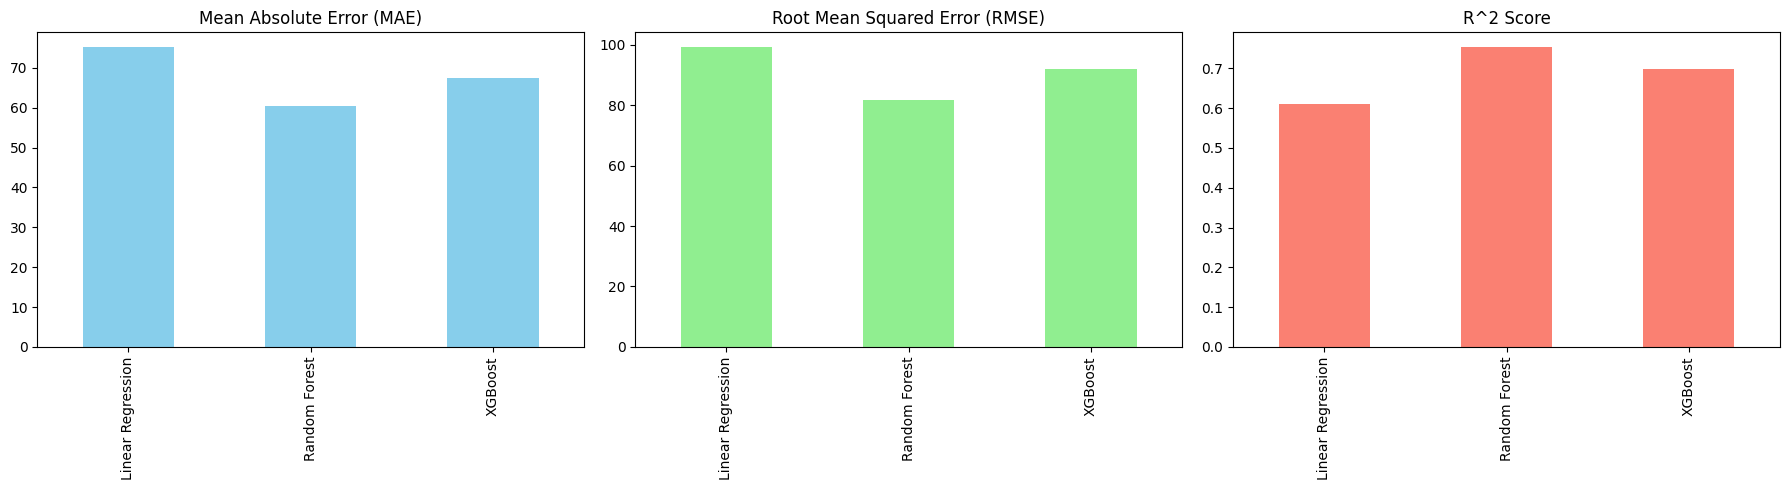

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # Store metrics
        metrics[name]['MAE'].append(mae)
        metrics[name]['RMSE'].append(rmse)
        metrics[name]['R2'].append(r2)

# Convert the metrics dictionary to a DataFrame for easy tabular representation
results_df = pd.DataFrame({name: {
    'MAE': np.mean(metrics[name]['MAE']),
    'RMSE': np.mean(metrics[name]['RMSE']),
    'R2': np.mean(metrics[name]['R2'])
} for name in models.keys()}).T  # Transpose to make models as rows

print("Average Metrics for Each Model:")
display(results_df)

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
results_df['MAE'].plot(kind='bar', ax=ax[0], color='skyblue', title='Mean Absolute Error (MAE)')
results_df['RMSE'].plot(kind='bar', ax=ax[1], color='lightgreen', title='Root Mean Squared Error (RMSE)')
results_df['R2'].plot(kind='bar', ax=ax[2], color='salmon', title='R^2 Score')
plt.tight_layout()
plt.show()


In [12]:
# Initialize variables to find the best model based on RMSE
best_model_name = None
best_rmse = float('inf')

# Iterate through the results to find the model with the lowest RMSE
for name, scores in metrics.items():
    avg_rmse = np.mean(scores['RMSE'])
    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_model_name = name

# Fit the best model on the entire dataset
best_model = models[best_model_name].fit(X, y)

# Save the best model
import pickle
pickle.dump(best_model, open(f"{best_model_name}_Baseline.pkl", 'wb'))

print(f"Saved {best_model_name} as the best model based on RMSE.")


Saved Random Forest as the best model based on RMSE.


In [14]:
# Initialize variables to find the best model based on R^2
best_model_name = None
best_r2 = float('-inf')  # Start with the lowest possible R^2

# Iterate through the results to find the model with the highest R^2
for name, scores in metrics.items():
    avg_r2 = np.mean(scores['R2'])
    if avg_r2 > best_r2:
        best_r2 = avg_r2
        best_model_name = name

# Fit the best model on the entire dataset
best_model = models[best_model_name].fit(X, y)

# Save the best model
import pickle
pickle.dump(best_model, open(f"{best_model_name}_Baseline.pkl", 'wb'))

print(f"Saved {best_model_name} as the best model based on R^2 score with an average R^2 of {best_r2:.3f}.")


Saved Random Forest as the best model based on R^2 score with an average R^2 of 0.753.


Week n+1 - Feature Selection

In [17]:
# Feature Selection with Random Forest (RF) and XGBoost (XGB)
#Train Models to Get Feature Importances

# Assuming X is a DataFrame where columns are feature names
# and y is the target variable.

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)
rf_importances = rf_model.feature_importances_

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)
xgb_importances = xgb_model.feature_importances_

# Create a DataFrame to visualize feature importances from both models
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'RF Importance': rf_importances,
    'XGB Importance': xgb_importances
})

# Sort the DataFrame to show more important features first
feature_importances = feature_importances.sort_values(by='RF Importance', ascending=False)

# Display the DataFrame
print(feature_importances)


         Feature  RF Importance  XGB Importance
21          zq65       0.269917        0.626739
22          zq70       0.140145        0.147737
24          zq80       0.116061        0.081965
23          zq75       0.105575        0.005119
20          zq60       0.062312        0.005836
3          zmean       0.041708        0.008478
19          zq55       0.033445        0.018350
18          zq50       0.027562        0.002620
25          zq85       0.026812        0.009429
26          zq90       0.015285        0.004483
36        zpcum9       0.013839        0.002486
9            zq5       0.012734        0.010938
27          zq95       0.010530        0.009664
17          zq45       0.010509        0.009521
2           zmax       0.009440        0.000854
4            zsd       0.009327        0.007010
35        zpcum8       0.008861        0.002171
29        zpcum2       0.007727        0.006425
7   pzabovezmean       0.007576        0.002620
33        zpcum6       0.006040        0

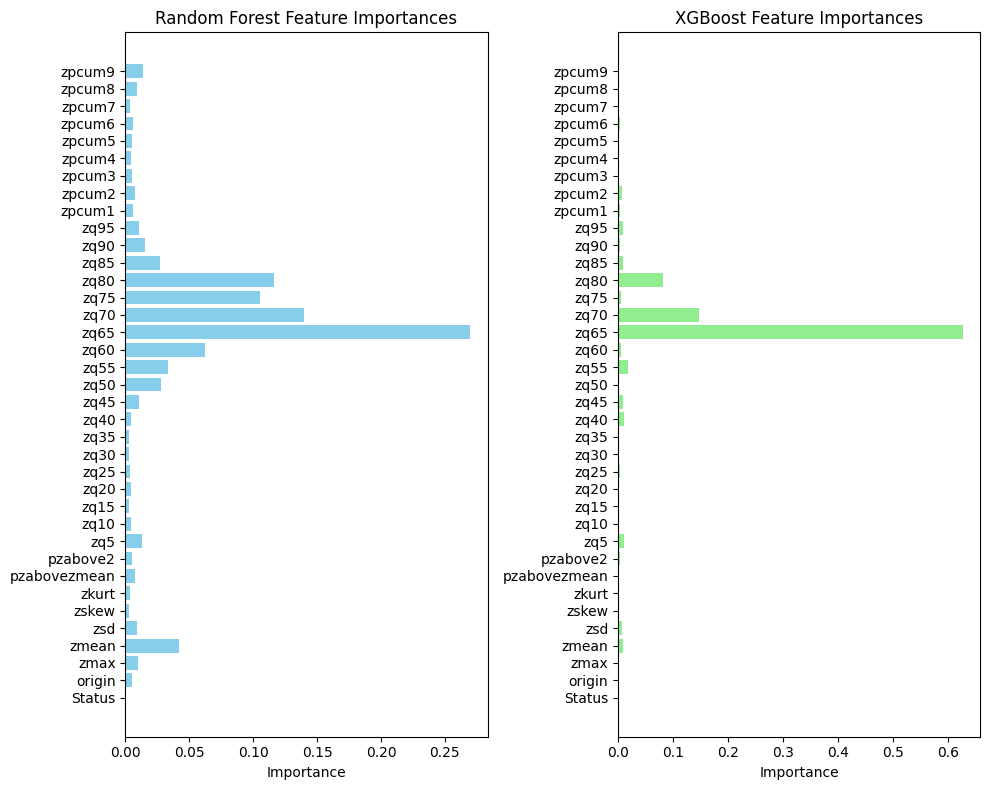

In [19]:
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

# Select features greater than the median importance
features_rf = X.columns[rf_importances > np.median(rf_importances)].tolist()
features_xgb = X.columns[xgb_importances > np.median(xgb_importances)].tolist()

# Save the selected features to JSON files
with open('Features_RF.json', 'w') as f:
    json.dump(features_rf, f)
with open('Features_XGB.json', 'w') as f:
    json.dump(features_xgb, f)

# Create a DataFrame to visualize feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'RF Importance': rf_importances,
    'XGB Importance': xgb_importances
})

# Visualizing feature importances
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.barh(feature_importances['Feature'], feature_importances['RF Importance'], color='skyblue')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')

plt.subplot(1, 2, 2)
plt.barh(feature_importances['Feature'], feature_importances['XGB Importance'], color='lightgreen')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

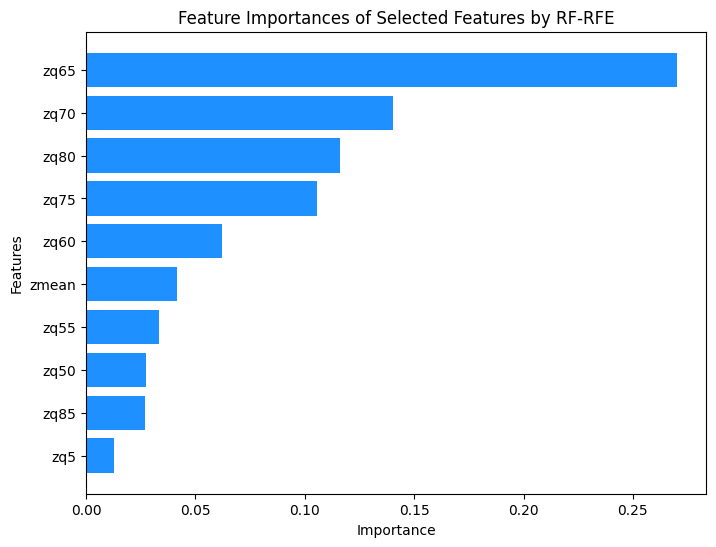

In [25]:
#RF-RFE (Recursive Feature Elimination with RF)
#Apply RFE


selector = RFE(rf_model, n_features_to_select=10, step=1)  # adjust 'n_features_to_select' as needed
selector.fit(X, y)

# Get the list of features selected by RFE
rfe_features = X.columns[selector.support_].tolist()

# Save the RFE features to JSON
with open('Features_RFE_RF.json', 'w') as f:
    json.dump(rfe_features, f)

# Extracting the importances of the selected features
rfe_importances = rf_model.feature_importances_[selector.support_]

# Create a DataFrame for visualization
rfe_feature_importances = pd.DataFrame({
    'Feature': rfe_features,
    'Importance': rfe_importances
}).sort_values(by='Importance', ascending=True)

# Visualize the feature importances
plt.figure(figsize=(8, 6))
plt.barh(rfe_feature_importances['Feature'], rfe_feature_importances['Importance'], color='dodgerblue')
plt.title('Feature Importances of Selected Features by RF-RFE')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


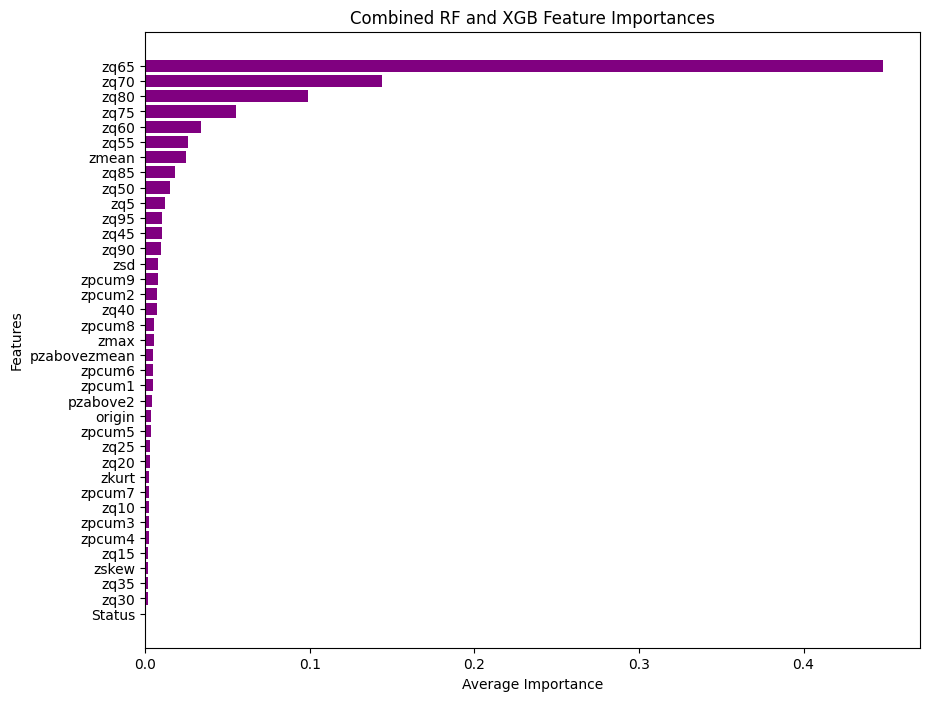

In [27]:
#Combined RF and XGB Feature Importances
#Combine and Select Features


xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X, y)
xgb_importances = xgb_model.feature_importances_

# Combine the importances
combined_importances = (rf_importances + xgb_importances) / 2

# Select features whose combined importance is greater than the median
selected_features = X.columns[combined_importances > np.median(combined_importances)].tolist()

# Save the selected features to JSON
with open('Features_RF_XGB.json', 'w') as f:
    json.dump(selected_features, f)

# Create a DataFrame for visualization
combined_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Combined Importance': combined_importances
}).sort_values(by='Combined Importance', ascending=True)

# Visualize the combined feature importances
plt.figure(figsize=(10, 8))
plt.barh(combined_feature_importances['Feature'], combined_feature_importances['Combined Importance'], color='purple')
plt.title('Combined RF and XGB Feature Importances')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.show()


zq65 importance came as most important

Cross Validation k fold

In [31]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score

# Load your dataset
df = pd.read_csv('tvol_lidarLiveP.csv')
X = df.drop('Target', axis=1)
y = df['Target']

# Set up KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)


In [33]:
# Paths to the feature sets
feature_set_files = {
    'RF': 'Features_RF.json',
    'RFE_RF': 'Features_RFE_RF.json',
    'RF_XGB': 'Features_RF_XGB.json',
    'XGB': 'Features_XGB.json'
}

# Load feature sets
feature_sets = {}
for key, filepath in feature_set_files.items():
    with open(filepath, 'r') as file:
        features = json.load(file)
        feature_sets[key] = features


In [35]:
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}


In [37]:
# Results dictionary to store the cross-validation results
results = {}

# Evaluate each feature set with each model
for feature_name, features in feature_sets.items():
    results[feature_name] = {}
    X_selected = X[features]
    for model_name, model in models.items():
        # Perform cross-validation
        scores = cross_val_score(model, X_selected, y, cv=kf, scoring='r2')  # Change scoring to 'neg_mean_squared_error' for RMSE
        results[feature_name][model_name] = np.mean(scores)

# Print the results
for feature_set, model_scores in results.items():
    print(f"Results for feature set {feature_set}:")
    for model_name, score in model_scores.items():
        print(f"  {model_name}: Average R^2 Score = {score}")


Results for feature set RF:
  Random Forest: Average R^2 Score = 0.7468044299714547
  XGBoost: Average R^2 Score = 0.6753995958178092
Results for feature set RFE_RF:
  Random Forest: Average R^2 Score = 0.7426608907484559
  XGBoost: Average R^2 Score = 0.6804236902897197
Results for feature set RF_XGB:
  Random Forest: Average R^2 Score = 0.7469853987156213
  XGBoost: Average R^2 Score = 0.6793311100067765
Results for feature set XGB:
  Random Forest: Average R^2 Score = 0.7442928549197744
  XGBoost: Average R^2 Score = 0.664405874957958


In [39]:
import json
import pickle

# Save the best feature sets for each model
best_features_rf = feature_sets['RF_XGB']
best_features_xgb = feature_sets['RFE_RF']

with open('Best_Features_RF.json', 'w') as f:
    json.dump(best_features_rf, f)

with open('Best_Features_XGB.json', 'w') as f:
    json.dump(best_features_xgb, f)

# Train and save the best models
best_model_rf = RandomForestRegressor(random_state=42)
best_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

best_model_rf.fit(X[best_features_rf], y)
best_model_xgb.fit(X[best_features_xgb], y)

with open('RF_RF_XGB.pkl', 'wb') as f:
    pickle.dump(best_model_rf, f)

with open('RFE_RF_XGB.pkl', 'wb') as f:
    pickle.dump(best_model_xgb, f)
